In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model

# For submission
test_dir = "test_petimages/"
submission_file = "submission.csv"

# For training and testing
train_dir = "train_petimages/"

cat_dir= os.path.join(train_dir, "cat")
dog_dir= os.path.join(train_dir, "dog")

First, I separated dogs images from cat images in data set. This container runs once only.

In [18]:
# Create directories
os.makedirs(cat_dir, exist_ok=True)
os.makedirs(dog_dir, exist_ok=True)

# Move files to appropriate directories
for file in os.listdir(train_dir):
    if file.startswith("cat"):
        shutil.move(os.path.join(train_dir, file), cat_dir)
    elif file.startswith("dog"):
        shutil.move(os.path.join(train_dir, file), dog_dir)



I created functions to clean data set from anomalies, and I used Pillow for opening, manipulating, and saving image files. I resized all images to 128x128 pixels and converted them to RGB. I also normalized the pixel values to be between 0 and 1.

In [2]:
def is_valid_image(file_path):
    try:
        img = Image.open(file_path)
        img.verify()
        return True
    except:
        return False
    
def clean_image_directory(base_dir):
    for root, directories, files in os.walk(base_dir):
        for file in files:
            file_path = os.path.join(root, file)
            if not is_valid_image(file_path):
                print(f"Removing {file_path}")
                os.remove(file_path)
    

def load_images(file_paths, labels=None, target_size=(128, 128)):
    images = []
    labels_list = []
    for i, file_path in enumerate(file_paths):
        try:
            img = Image.open(file_path).convert("RGB").resize(target_size)
            images.append(np.array(img) / 255.0)
            if labels is not None:
                labels_list.append(labels[i])
        except Exception as e:
            print(f"Error loading image {file_path}: {e}")
    return np.array(images), np.array(labels_list) if labels is not None else None

clean_image_directory(train_dir)

Then, I split the train_petimages cats and dogs data sets into 2 parts, one for training (75%) and one for testing (25%), and I configured data augmentation for the training data set.

In [18]:
# Define paths
train_dir = "train_petimages/"
test_dir = "test_petimages/"

# Data augmentation for training data
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2, 
    height_shift_range=0.2,
    shear_range=0.2,      
    zoom_range=0.25,       
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.6, 1.1], 
    validation_split=0.25
)

# Generators with optimized batch size
train_generator = data_gen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,           
    class_mode='binary',
    subset='training'
)

validation_generator = data_gen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,          
    class_mode='binary',
    subset='validation'
)

# Optimized callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,            
    patience=4,
    min_lr=1e-7
)

checkpoint = ModelCheckpoint(
    filepath='Models/best_model.h5',
    monitor='val_accuracy',
    save_best_only=True
)

Found 14999 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


In [19]:
# the CNN model
model = Sequential([
    Input(shape=(64, 64, 3)),  # Reduced input size
    
    # First block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Second block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Third block
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Fourth block
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.0001)), 
    Dropout(0.5),  
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss='binary_crossentropy',
    metrics=['accuracy']
)

I load the previous model and try to retrain it.

In [9]:
os.makedirs("Models", exist_ok=True)
model = load_model('Models/best_model.h5')
model.save('Models/backup_model.h5')

d:\Work\04_Program-Files\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=30,              
    verbose=1,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

Epoch 1/30
469/469 [==============================] - 1176s 3s/step - loss: 0.7556 - accuracy: 0.6172 - val_loss: 0.7338 - val_accuracy: 0.6192 - lr: 1.0000e-04
Epoch 2/30


d:\Work\04_Program-Files\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


469/469 [==============================] - 1150s 2s/step - loss: 0.6579 - accuracy: 0.6659 - val_loss: 0.6276 - val_accuracy: 0.6853 - lr: 1.0000e-04
Epoch 3/30
469/469 [==============================] - 1135s 2s/step - loss: 0.6286 - accuracy: 0.6943 - val_loss: 0.5997 - val_accuracy: 0.7151 - lr: 1.0000e-04
Epoch 4/30
469/469 [==============================] - 1136s 2s/step - loss: 0.5926 - accuracy: 0.7240 - val_loss: 0.6169 - val_accuracy: 0.6965 - lr: 1.0000e-04
Epoch 5/30
469/469 [==============================] - 1136s 2s/step - loss: 0.5638 - accuracy: 0.7457 - val_loss: 0.5446 - val_accuracy: 0.7537 - lr: 1.0000e-04
Epoch 6/30
469/469 [==============================] - 1130s 2s/step - loss: 0.5345 - accuracy: 0.7638 - val_loss: 0.5285 - val_accuracy: 0.7705 - lr: 1.0000e-04
Epoch 7/30
469/469 [==============================] - 1129s 2s/step - loss: 0.5234 - accuracy: 0.7741 - val_loss: 0.5569 - val_accuracy: 0.7419 - lr: 1.0000e-04
Epoch 8/30
469/469 [=========================

I run this only if the results after retraining the model are not good enough, and I want to try a new model.

In [12]:
model = load_model('Models/backup_model.h5')

In [ ]:
import matplotlib.pyplot as plt
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
# Predict on test data
def predict_test_images(test_dir, model, output_csv):
    test_files = [f for f in os.listdir(test_dir) if f.endswith(('jpg', 'jpeg', 'png'))]
    results = []

    for file in test_files:
        try:
            img_path = os.path.join(test_dir, file)
            img = Image.open(img_path).convert("RGB").resize((64, 64))
            img_array = np.array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)

            prediction = model.predict(img_array, verbose=0)
            label = 'dog' if prediction[0][0] > 0.5 else 'cat'

            file_name_without_ext = os.path.splitext(file)[0]
            results.append((file_name_without_ext, label))

        except Exception as e:
            print(f"Error processing file {file}: {e}")

    df = pd.DataFrame(results, columns=['ImageId', 'Label'])
    df.to_csv(output_csv, index=False)

# Generate predictions and save to CSV
output_csv = "submission.csv"
predict_test_images(test_dir, model, output_csv)

d:\Work\04_Program-Files\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


A simple function to plot a number of images from the training set was created to visualize the data.

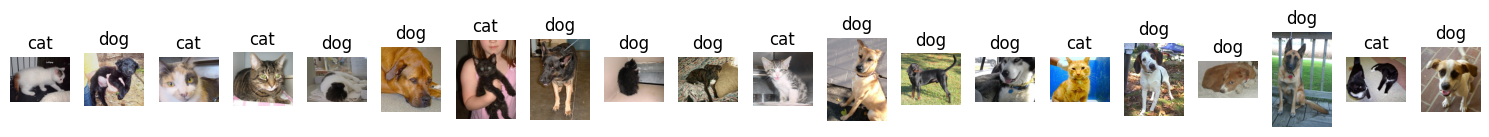

In [33]:
csv_file = 'submission.csv'
image_dir = 'test_petimages'

data = pd.read_csv(csv_file,dtype={'ImageId': str})

def display_images(data, image_dir, num_images=5, extension='.jpg'):
    """
    Display a few images with their labels from a CSV file.
    
    Parameters:
    - data (DataFrame): DataFrame containing 'ImageId' and 'Label' columns.
    - image_dir (str): Directory containing the images.
    - num_images (int): Number of images to display.
    """
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, ax in enumerate(axes):
        if i >= len(data):
            break
        
        image_name = str(data.iloc[i]['ImageId'])
        label = data.iloc[i]['Label']
        image_path = os.path.join(image_dir, image_name+extension)

        try:
            img = Image.open(image_path)
            ax.imshow(img)
            ax.axis('off')  # Hide axes
            ax.set_title(label)  # Set label as the title
        except FileNotFoundError:
            ax.set_title(f"Image not found: {image_name}")
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

display_images(data, image_dir, num_images=20,extension='.jpg')
